In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('Ïñçüí¢')

Ïñçüí¢


In [29]:
train_data_path = join('data', 'train.csv')
sub_data_path = join('data', 'test.csv')

In [31]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [33]:
y = data['price']
del data['price']

print(data.columns)

KeyError: 'price'

In [35]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

27971


In [37]:
data.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

<AxesSubplot:>

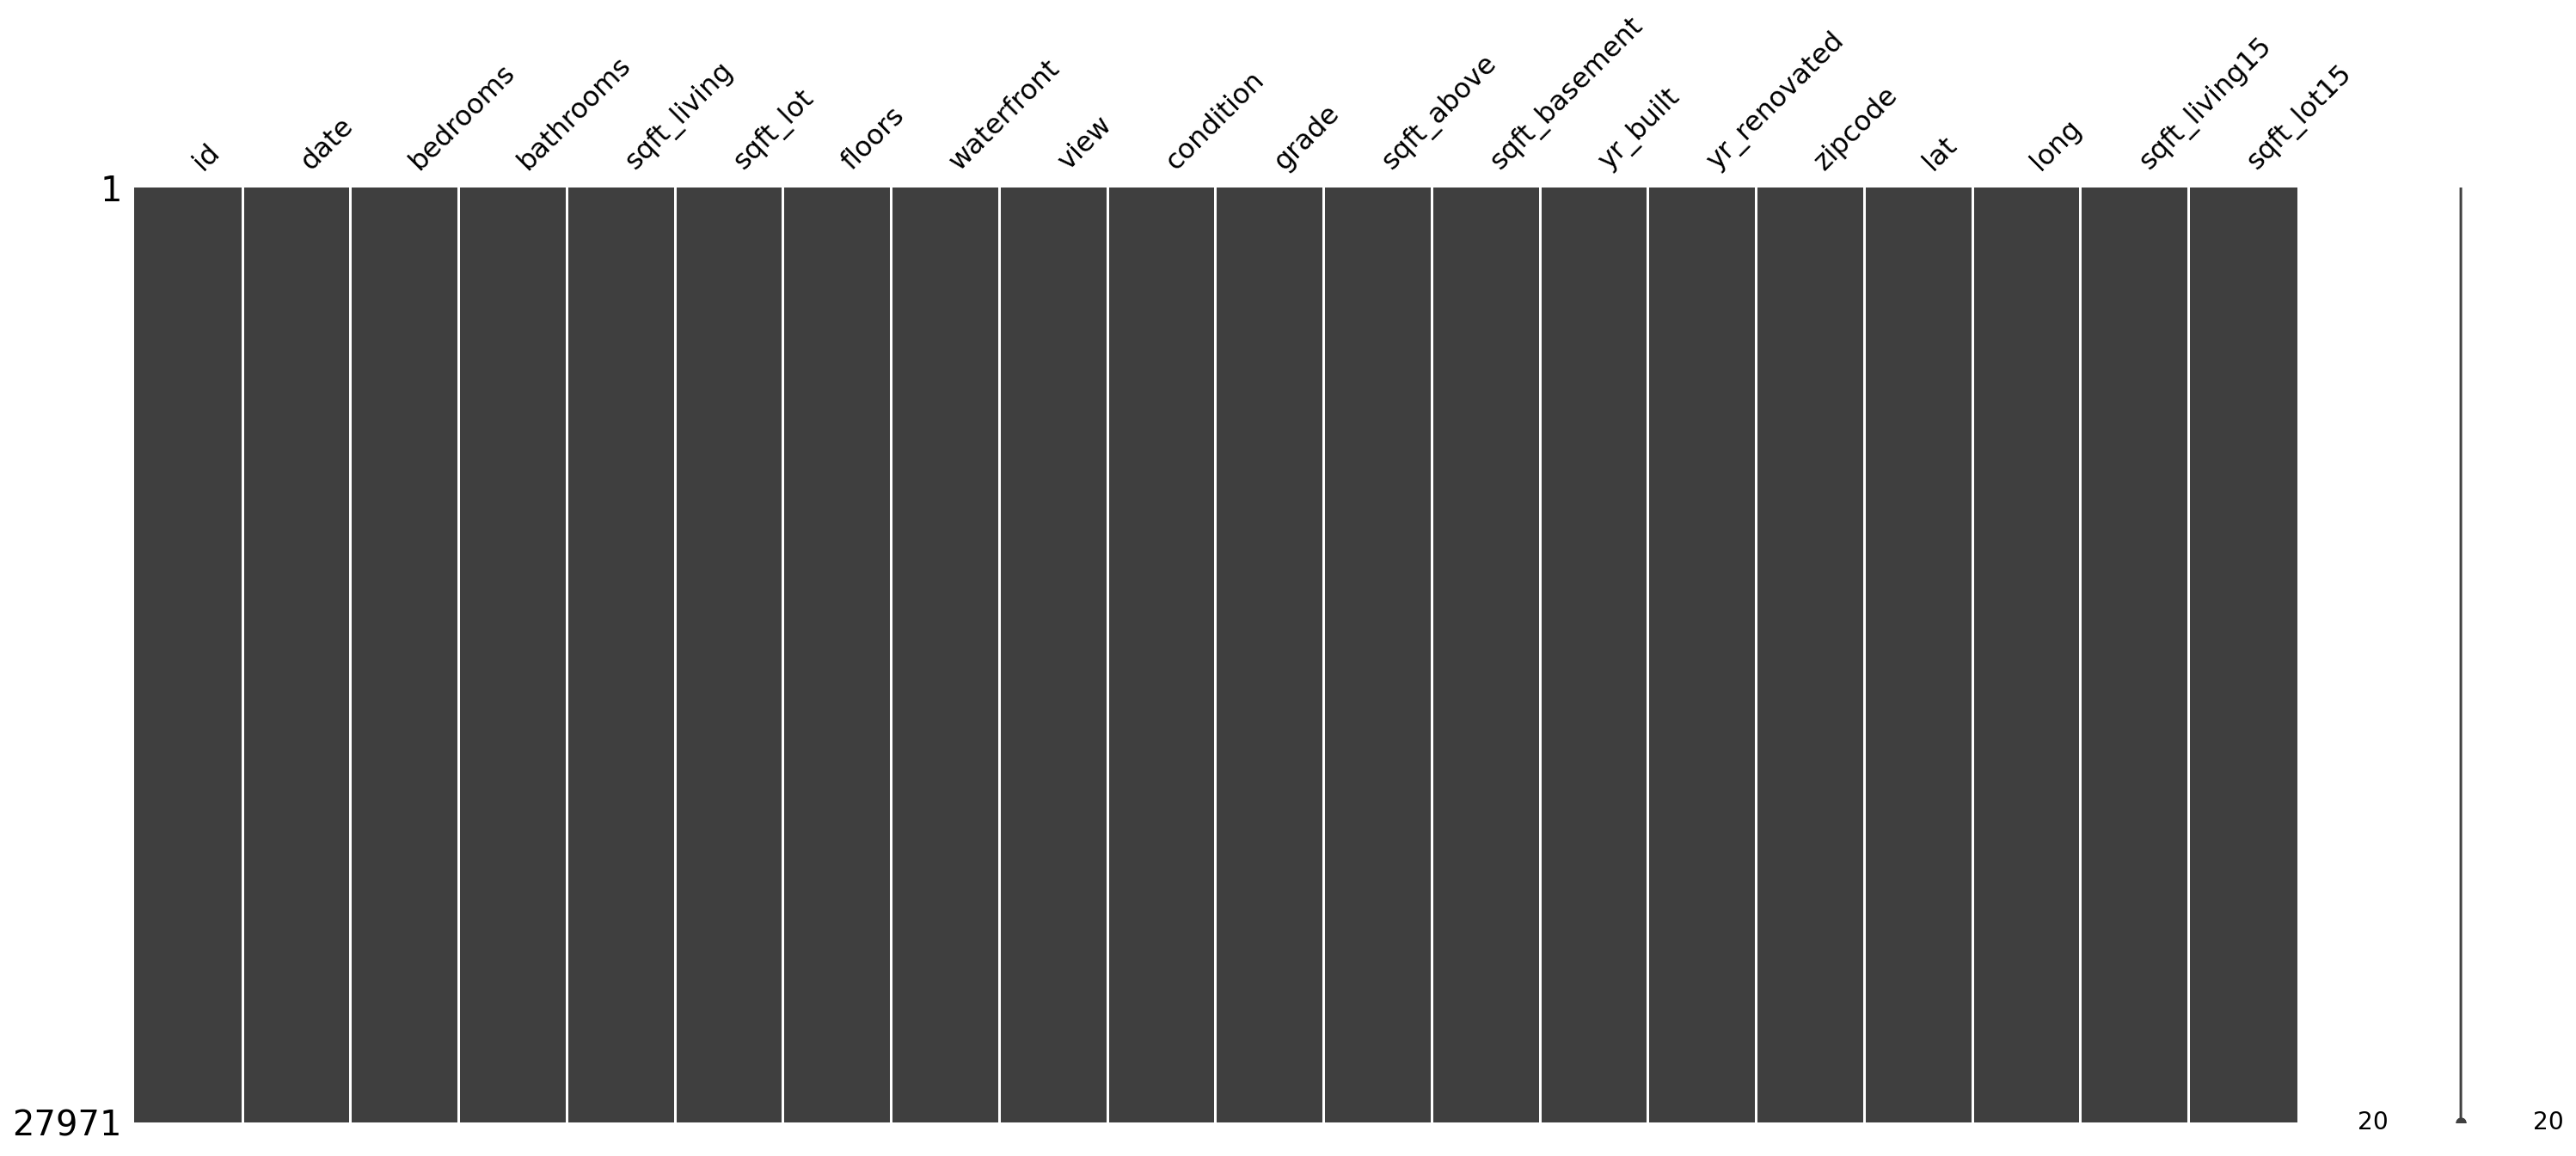

In [39]:
msno.matrix(data)

In [40]:
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 27971, dtype: bool


In [42]:
# 2. Í≤∞Ï∏°ÏπòÏù∏ Îç∞Ïù¥ÌÑ∞Îßå ÎΩëÏïÑÎÉÖÎãàÎã§.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [43]:
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [44]:
# Ìïú Î≤àÏóê ÎøÖ!
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [45]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [49]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

KeyError: 'id'

In [51]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3       1.00         1180      5650     1.0           0   
1  201502         2       1.00          770     10000     1.0           0   
2  201502         3       2.00         1680      8080     1.0           0   
3  201406         3       2.25         1715      6819     2.0           0   
4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

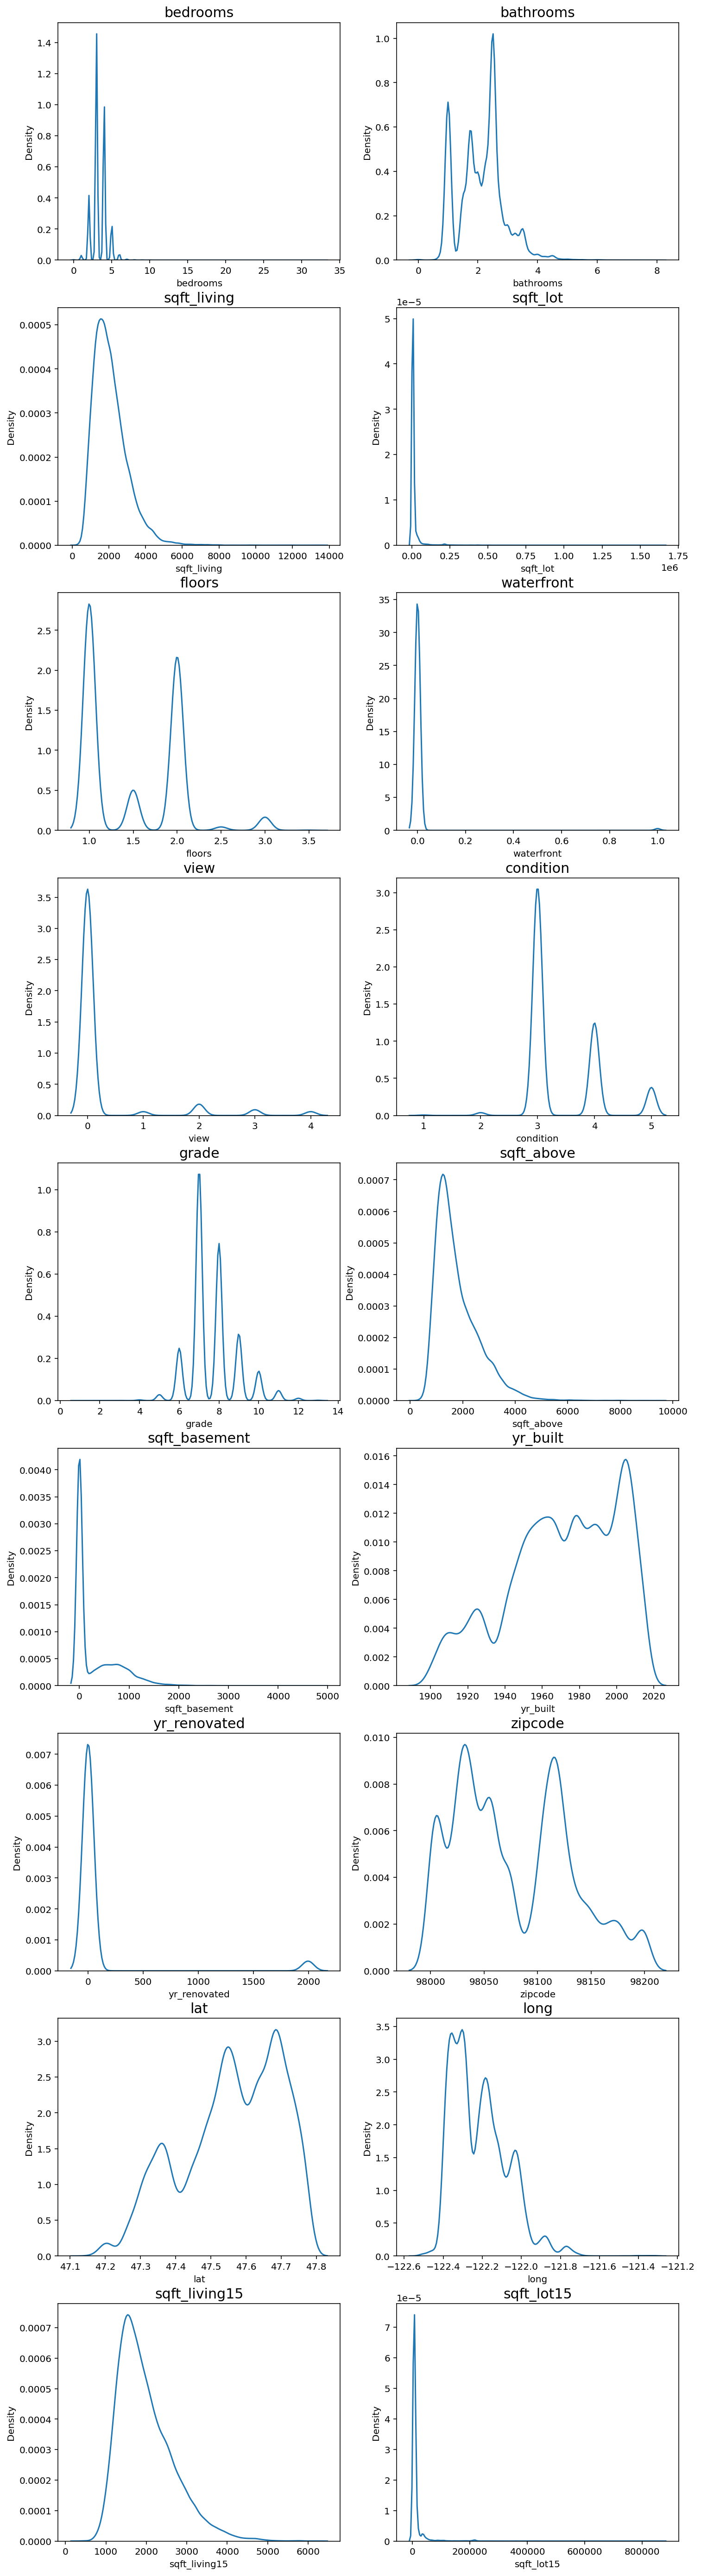

In [53]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # Í∞ÄÎ°úÏä§ÌÅ¨Î°§ ÎïåÎ¨∏Ïóê Í∑∏ÎûòÌîÑ ÌôïÏù∏Ïù¥ Î∂àÌé∏ÌïòÎã§Î©¥ figsizeÏùò xÍ∞íÏùÑ Ï°∞Ï†àÌï¥ Î≥¥ÏÑ∏Ïöî.

# id Î≥ÄÏàò(count==0Ïù∏ Í≤ΩÏö∞)Îäî Ï†úÏô∏ÌïòÍ≥† Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï©ÎãàÎã§.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [54]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('Ïñçüí¢')

Ïñçüí¢


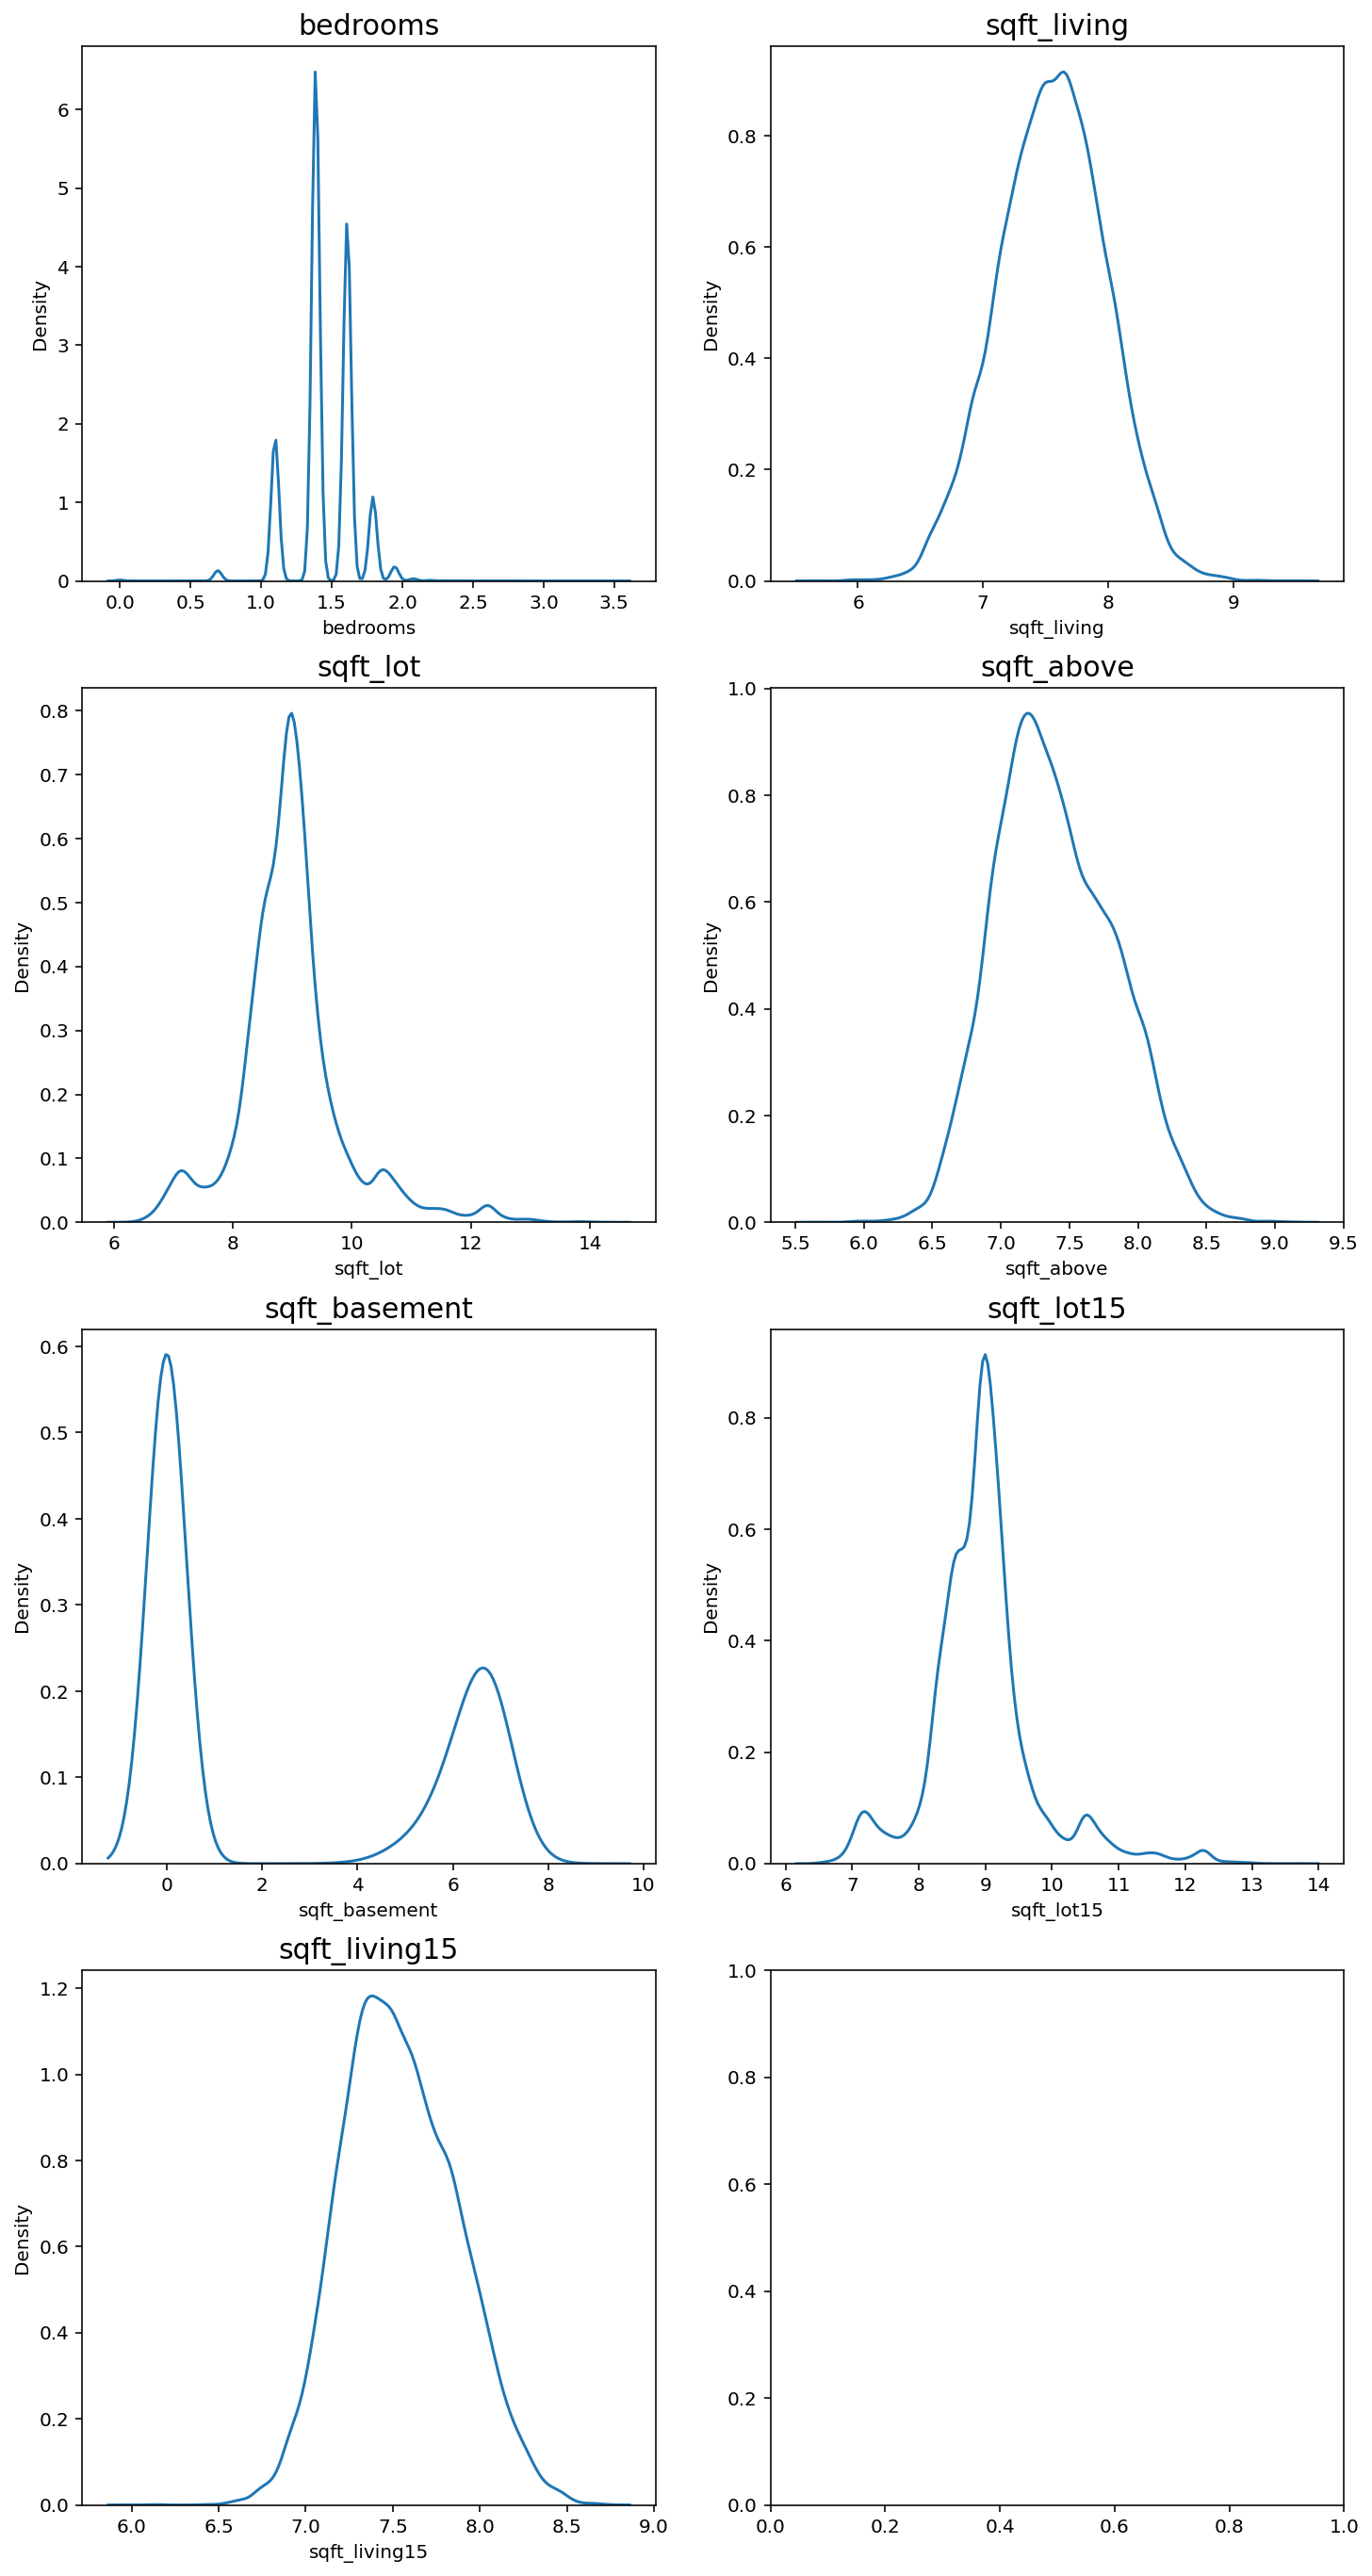

In [55]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [66]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(21503, 19)
(6468, 19)


In [67]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('Ïñçüí¢')

Ïñçüí¢


In [68]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('Ïñçüí¢')

Ïñçüí¢


In [69]:
get_cv_score(models)

ValueError: Found input variables with inconsistent numbers of samples: [21503, 15035]

In [71]:
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y)

    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('Ïñçüí¢')

Ïñçüí¢


In [73]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

ValueError: Found input variables with inconsistent numbers of samples: [21503, 15035]

In [75]:
submission_path = join('data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [77]:
result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

id         price
0  15035  5.299667e+05
1  15036  4.307262e+05
2  15037  1.361677e+06
3  15038  3.338036e+05
4  15039  3.089006e+05

In [79]:
my_submission_path = join('data', 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

data/submission.csv
